The main goal is to analyze customer reviews and understand their sentiment using two different approaches: a lexicon-based method (VADER) and a deep learning model (Roberta).

In [1]:
# Mount Google Drive to access data (Colab specific)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Print current working directory (for debugging purposes)
!pwd

/content


In [3]:
# List contents of mounted drive (helpful for initial exploration)
!ls'drive/'

/bin/bash: line 1: lsdrive/: No such file or directory


In [4]:
# Import necessary libraries for data manipulation, visualization, NLP tasks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

# Set plotting style for consistency
plt.style.use('ggplot')


# Download required NLTK resources for tokenization, POS tagging, named entity chunking
import nltk
nltk.download('punkt')  # Sentence tokenization
nltk.download('averaged_perceptron_tagger')  # Part-of-speech tagging
nltk.download('maxent_ne_chunker')  # Named entity recognition
nltk.download('words')  # Additional vocabulary resources
nltk.download('vader_lexicon')  # Lexicon for VADER sentiment analysis

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [5]:
# Load pre-trained sentiment analysis model (Transformers)
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [6]:
# Unzip compressed data file from Google Drive (Colab specific)
!unzip "/content/drive/MyDrive/sentiment_data/Reviews.csv.zip" -d /content

Archive:  /content/drive/MyDrive/sentiment_data/Reviews.csv.zip
  inflating: /content/Reviews.csv    


In [7]:
# Check data size after unzipping
!du -h '/content/Reviews.csv'

287M	/content/Reviews.csv


In [8]:
# Read data into pandas dataframe
df = pd.read_csv('/content/Reviews.csv')
print(df.shape)
# Limit data for faster exploration (can be adjusted based on needs)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [9]:
# Preview first few rows of data
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
# Get first text entry for analysis
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

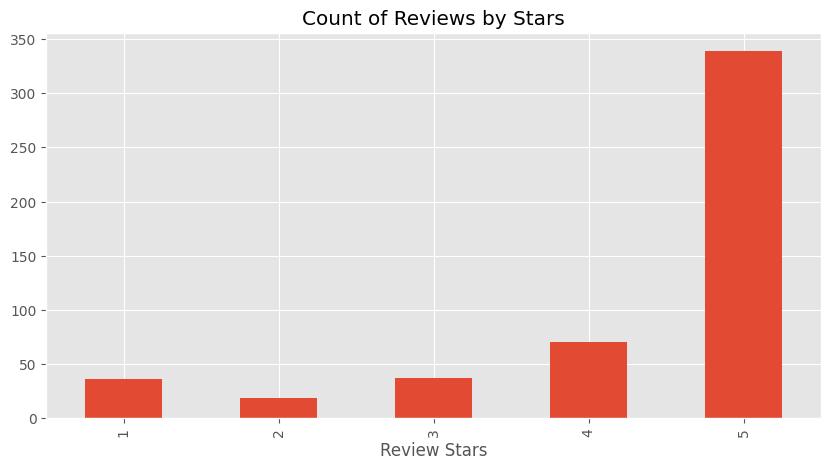

In [13]:
#Plotting Score

ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

In [16]:
# Get first text entry for analysis
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [20]:
# Tokenize the example text (split into words)
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

You can delete also stop words, links and so on in there.
In nowaday technology NLP engineers use LangChain

In [21]:
# Perform Part-of-Speech (POS) tagging on tokens
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [22]:
# Identify named entities in the text
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()  # Pretty print named entity chunks

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


### Vader-based sentiment analysis

VADER (Valence Aware Dictionary and Sentiment Reasoner) - Bag of words approach




In [23]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

Polarity Score : Example sentiment scores using VADER

In [24]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [25]:
 example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [26]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [27]:
sia.polarity_scores(example)


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [28]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
# Convert sentiment scores dictionary to dataframe
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
# Merge sentiment scores with original data for analysis
vaders = vaders.merge(df, how='left')

In [30]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


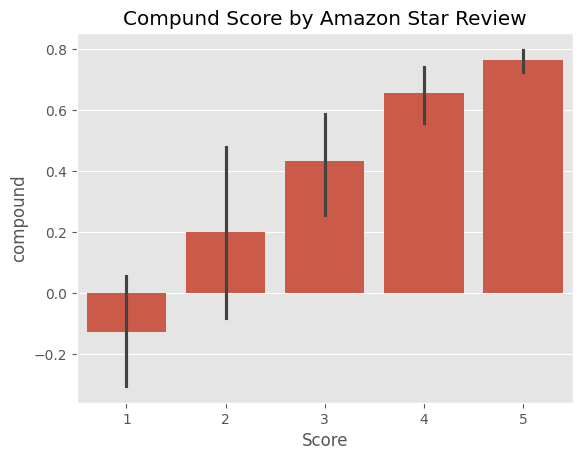

In [31]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

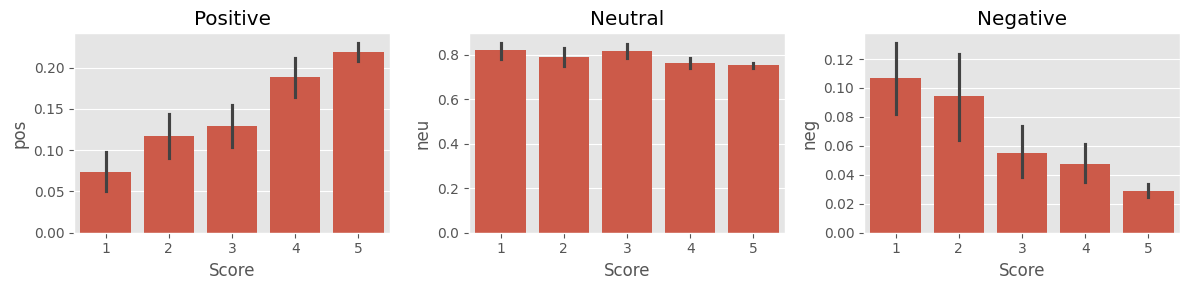

In [32]:
# Breakdown of sentiment scores (positive, neutral, negative) by star rating
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

### Roberta-based sentiment analysis

In [33]:
# Define pre-trained Roberta model and tokenizer for sentiment analysis
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [34]:
# Run sentiment analysis for a single example using Roberta
encoded_text = tokenizer(example, return_tensors='pt')  # Encode text for the model
output = model(**encoded_text)  # Get model output
scores = output[0][0].detach().numpy()  # Extract raw scores
scores = softmax(scores)  # Apply softmax for normalized probabilities
scores_dict = {  # Create dictionary for sentiment labels and scores
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)  # Print the Roberta sentiment scores

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [35]:
# Define function for Roberta sentiment analysis on any text
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [36]:
# Calculate sentiment scores for all reviews using Roberta and VADER
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        # VADER sentiment analysis
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}
        # Roberta sentiment analysis using the defined function
        roberta_result = polarity_scores_roberta(text)
        # Combine VADER and Roberta results into a single dictionary
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')  # Handle potential errors during processing

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [37]:
# Convert sentiment score results to dataframe
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [38]:
# Print column names of the final dataframe for reference
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

### The Transformers Pipeline

In [39]:
from transformers import pipeline
# Create a sentiment analysis pipeline from the Transformers library
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Use the pipeline for sentiment analysis on various examples

In [40]:
sent_pipeline('I love sentiment analysis!')


[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [41]:
sent_pipeline('Machine learning is very easy to learn!')


[{'label': 'POSITIVE', 'score': 0.9975710511207581}]

In [42]:
sent_pipeline('I have no idea!')


[{'label': 'NEGATIVE', 'score': 0.9916845560073853}]

In [43]:
sent_pipeline("I don't like it")

[{'label': 'NEGATIVE', 'score': 0.9978170394897461}]